# Sex Prediction
Total data size is n=500 from UK Biobank, consisting of Structural, resting state functional, and diffusion-weighted MRI with Demographic information. 

Each dataset, train and test, includes 'Images' and matched 'Features'; 
- Grey Matter Map (GM)
- White Matter Map (WM)
- Fractional Anisotropy Map (FA)
- Mean Diffusivity Map (MD)


&rarr; Goal: Predict the given subject's sex.

### Import Modules & Basic Settings

In [1]:
# %pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import os, time
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy

import nibabel as nib
from nilearn import plotting
import nilearn.image as nli

import shap

import warnings
warnings.filterwarnings('ignore')

### Set Options

In [3]:
# GPU Setting
torch.cuda.set_device(1)
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print('Device:', device)

# Base Directory
root_dir = '/home/jiwon/MedicalBioResearch/Prediction_Sex/'
os.chdir(root_dir)
print(os.getcwd())

# Path to Data
image_data = 'data/images/'
train_data_path = root_dir+image_data+'train/'
test_data_path = root_dir+image_data+'test/'

# Selected Modalities
modalities = ["GM"]#, "WM", "MD", "FA"]
additional_variables = ["Sex", "Age"]

Device: cuda:1
/home/jiwon/MedicalBioResearch/Prediction_Sex


In [4]:
# Hyper-Parameters Setting
criterion = torch.nn.CrossEntropyLoss()
batch_size = 4
max_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-5
val_interval = 1

### Load Train Data

In [5]:
# Data Transform
class ToTensor3D:
    def __call__(self, image):
        return torch.from_numpy(image).float()

class Normalize3D:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

mean = [0.5] * len(modalities) 
std = [0.5] * len(modalities) 

from torchvision import transforms
transform = transforms.Compose([
    ToTensor3D(),
    Normalize3D(mean, std)
])

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, modalities, additional_variables, transform=None, inference=False):
        self.data = data
        self.modalities = modalities
        self.additional_variables = additional_variables
        self.transform = transform
        self.inference = inference

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        images = []

        for modality in self.modalities:
            image_path = sample[modality]
            image = nib.load(image_path).get_fdata()
            image = np.expand_dims(image, axis=0)  # Add channel dimension
            if self.transform:
                image = self.transform(image)
            images.append(image)    # (3, 79, 95, 79)

        images = np.concatenate(images, axis=0)
        images = torch.tensor(images, dtype=torch.float32)

        additional_data = []
        for var in self.additional_variables:
            if var != 'Sex':
                additional_data.append(sample[var])
        additional_data = torch.tensor(additional_data, dtype=torch.float32)

        if self.inference:
            return images, additional_data
        else:
            sex = torch.tensor(sample['Sex'], dtype=torch.long)
            return images, additional_data, sex

In [7]:
# Load Data (Train)
train_df = pd.read_csv(os.path.join(train_data_path, 'Subjects.csv'))
print(train_df.head())
train_subjects = train_df['ID'].to_numpy()
train_data_dicts = []

for index, subject in enumerate(train_subjects):
    subject_dict = {}
    for modality in modalities:
        subject_dict[modality] = os.path.join(train_data_path, modality, f"{subject:03d}.nii.gz")
    for variable in additional_variables:
        subject_dict[variable] = train_df[variable].to_numpy()[index]
    train_data_dicts.append(subject_dict)

# Convert the Format of Dictionary to Split the Dataset 
train_data_df = pd.DataFrame(train_data_dicts)
train_data, val_data = train_test_split(train_data_df, test_size=0.2, random_state=42)
train_data_dicts, val_data_dicts = train_data.to_dict('records'), val_data.to_dict('records')

train_dataset = CustomDataset(train_data_dicts, modalities, additional_variables, transform=transform)
val_dataset = CustomDataset(val_data_dicts, modalities, additional_variables, transform=transform)

# Define Data Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, pin_memory=torch.cuda.is_available())

   ID  Sex  Age
0   1    1   55
1   2    0   54
2   3    1   54
3   4    1   55
4   5    1   57


In [8]:
# Exract First Batch
tr_batch_first = next(iter(train_dataset))
print(tr_batch_first[0].shape)

torch.Size([1, 79, 95, 79])


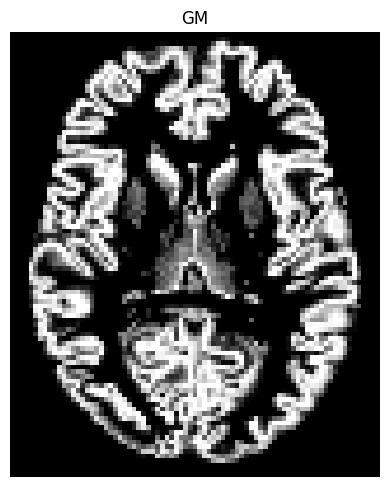

In [9]:
# Visualize
fig, axes = plt.subplots(1, len(modalities), figsize=(len(modalities) * 4, 5))
for i, key in enumerate(modalities):
    image = tr_batch_first[0][i]
    image_2d = np.squeeze(image[:, :, image.shape[2] // 2])
    axes.imshow(np.rot90(image_2d), cmap='gray')
    axes.set_title(key)
    axes.axis('off')
plt.tight_layout()
plt.show()

### Model

In [10]:
class CustomRegressor(nn.Module):
    ### Confirm Params
    def __init__(self, input_channels=3, additional_features=1, out_features=2):
        super(CustomRegressor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(input_channels, 16, kernel_size=3, stride=2, padding=1), # input: 79x95x79
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1), # input: 40x48x40
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1), # input: 20x24x20
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1), # input: 10x12x10
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1), # input: 5x6x5 --> output: 2x3x2
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 3 * 3 * 3 + additional_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, out_features)
        )

    def forward(self, x, y):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.cat((x, y), dim=1)
        x = self.fc_layers(x)
        return x

In [11]:
# Model, Optimizer, and Scheduler Setup
model = CustomRegressor(input_channels=len(modalities), additional_features=1, out_features=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [12]:
print('Device:', device)
print(torch.cuda.is_available())

Device: cuda:1
True


In [13]:
# Training Loop
start_time = time.time()
best_metric, best_metric_epoch = -1, -1
epoch_loss_values, epoch_metric_values, metric_values = [], [], []

max_epochs = 20
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    epoch_start_time = time.time()

    for batch_data in train_loader:
        optimizer.zero_grad()

        images = batch_data[0].to(device)
        additional_data = batch_data[1].to(device)
        labels = batch_data[2].to(device)

        outputs = model(images, additional_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
        correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()

    epoch_loss /= total_samples
    epoch_accuracy = correct_predictions / total_samples

    epoch_loss_values.append(epoch_loss)
    epoch_metric_values.append(epoch_accuracy)
    epoch_time = time.time() - epoch_start_time

    print(f'Epoch {epoch+1}/{max_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f} ({int(epoch_time)} sec)')

    # Validation
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_correct_predictions = 0
        val_total_samples = 0
        with torch.no_grad():

            for val_batch_data in val_loader:
                val_images = val_batch_data[0].to(device)
                val_additional_data = val_batch_data[1].to(device)
                val_labels = val_batch_data[2].to(device)

                val_outputs = model(val_images, val_additional_data)
                val_total_samples += val_labels.size(0)
                # _, val_preds = torch.max(val_outputs, 1)
                # val_correct_predictions += (val_preds == val_labels).sum().item()
                val_correct_predictions += (val_outputs.argmax(dim=1) == val_labels).sum().item()

        val_accuracy = val_correct_predictions / val_total_samples
        metric_values.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_metric:
            best_metric = val_accuracy
            best_metric_epoch = epoch + 1
            best_model_wts = model.state_dict()
            logging.info(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")

    lr_scheduler.step()

    epoch_end_time = time.time()
    logging.info(f"Epoch {epoch + 1} computed for {(epoch_end_time - epoch_start_time)/60:.2f} mins - Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_accuracy:.4f}, Validation accuracy: {val_accuracy:.4f}")

end_time = time.time()
total_time = int(end_time - start_time)

torch.save(best_model_wts, os.path.join(root_dir, "BestMetricModel_Edited_1.pth"))
logging.info(f"Best accuracy: {best_metric:.3f} at epoch {best_metric_epoch}; Total time consumed: {total_time//60} mins {total_time%60} sec")

print()
print(f"Best accuracy: {best_metric:.3f} at epoch {best_metric_epoch}; Total time consumed: {total_time//60} mins {total_time%60} sec")

Epoch 1/20, Loss: 0.6993, Accuracy: 0.4694 (36 sec)
Validation Accuracy: 0.4444
Epoch 2/20, Loss: 0.6935, Accuracy: 0.5111 (59 sec)
Validation Accuracy: 0.4444
Epoch 3/20, Loss: 0.6880, Accuracy: 0.5139 (67 sec)
Validation Accuracy: 0.4444
Epoch 4/20, Loss: 0.5970, Accuracy: 0.7000 (64 sec)
Validation Accuracy: 0.7778
Epoch 5/20, Loss: 0.2745, Accuracy: 0.9000 (62 sec)
Validation Accuracy: 0.8444
Epoch 6/20, Loss: 0.1254, Accuracy: 0.9611 (66 sec)
Validation Accuracy: 0.8667
Epoch 7/20, Loss: 0.0398, Accuracy: 0.9944 (66 sec)
Validation Accuracy: 0.8778
Epoch 8/20, Loss: 0.0099, Accuracy: 1.0000 (60 sec)
Validation Accuracy: 0.8778
Epoch 9/20, Loss: 0.0059, Accuracy: 1.0000 (65 sec)
Validation Accuracy: 0.8778
Epoch 10/20, Loss: 0.0033, Accuracy: 1.0000 (67 sec)
Validation Accuracy: 0.8778
Epoch 11/20, Loss: 0.0024, Accuracy: 1.0000 (60 sec)
Validation Accuracy: 0.8778
Epoch 12/20, Loss: 0.0015, Accuracy: 1.0000 (65 sec)
Validation Accuracy: 0.8667
Epoch 13/20, Loss: 0.0015, Accuracy: 

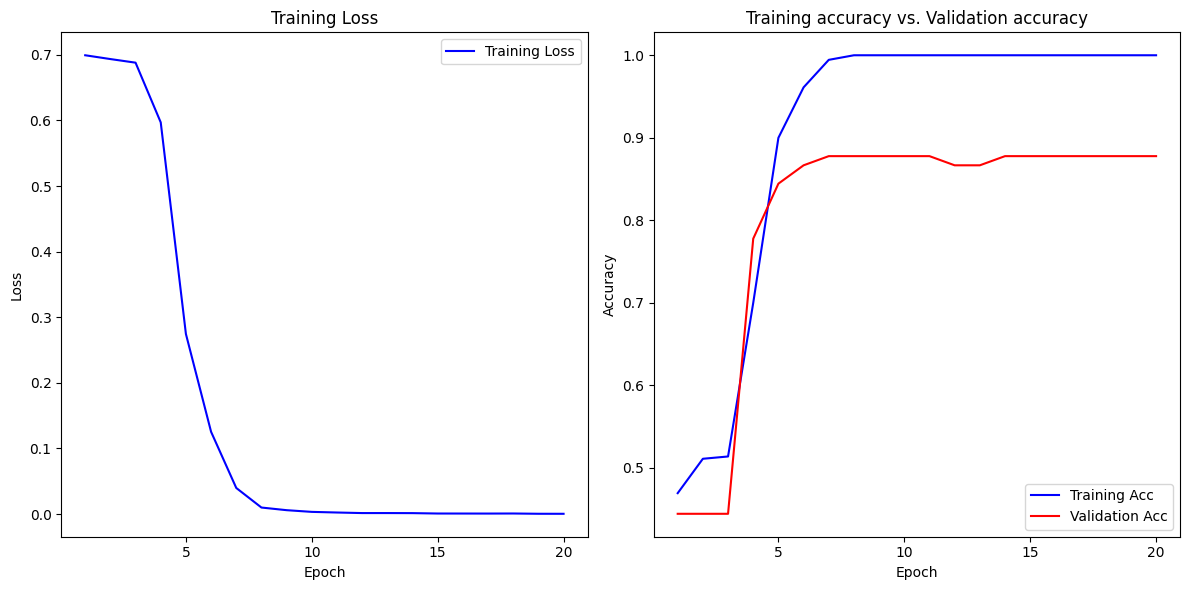

In [32]:
# Plotting the Results
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(np.linspace(0,1,5)*len(epoch_metric_values))
axes[0].plot( [i + 1 for i in range(len(epoch_loss_values))], epoch_loss_values, label='Training Loss', color='blue')
axes[0].legend()

axes[1].set_title('Training accuracy vs. Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(np.linspace(0,1,5)*len(epoch_metric_values))
axes[1].plot([i + 1 for i in range(len(epoch_metric_values))], epoch_metric_values, label='Training Acc', color='blue')
axes[1].plot([val_interval * (i + 1) for i in range(len(metric_values))], metric_values, label='Validation Acc', color='red')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(root_dir, "Performance_1.png"), dpi=300)


### Load Test Data

In [15]:
### Load Data (Test)
test_df = pd.read_csv(os.path.join(test_data_path, 'Subjects.csv'))
print(test_df.head())
test_subjects = test_df['ID'].to_numpy()
test_data_dicts = []

for index, subject in enumerate(test_subjects):
    subject_dict = {}
    for modality in modalities:
        subject_dict[modality] = os.path.join(test_data_path, modality, f"{subject:03d}.nii.gz")
    subject_dict["Age"] = test_df["Age"].to_numpy()[index]
    test_data_dicts.append(subject_dict)

test_dataset = CustomDataset(test_data_dicts, modalities, additional_variables, transform=transform, inference=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, pin_memory=torch.cuda.is_available())

   ID  Age
0   1   55
1   2   55
2   3   56
3   4   58
4   5   57


### Inference

In [34]:
# Inference
model.load_state_dict(torch.load(os.path.join(root_dir, "BestMetricModel_Edited_1.pth")))
model.eval()
predictions = []
with torch.no_grad():

    for test_batch_data in test_loader:
        test_images = test_batch_data[0].to(device)
        test_additional_data = test_batch_data[1].to(device)

        test_outputs = model(test_images, test_additional_data)
        _, test_preds = torch.max(test_outputs, 1)
        predictions.extend(test_preds.cpu().numpy())

# Convert predictions to DataFrame
np.savetxt(os.path.join(root_dir, "Predictions_1.txt"), predictions)
test_df['Predicted_Sex'] = predictions
print(test_df.head(10))

   ID  Age  Predicted_Sex
0   1   55              1
1   2   55              0
2   3   56              1
3   4   58              1
4   5   57              1
5   6   55              0
6   7   54              1
7   8   58              0
8   9   57              1
9  10   56              1


In [33]:
np.savetxt(os.path.join(root_dir, "Loss_train_1.txt"), epoch_loss_values)
np.savetxt(os.path.join(root_dir, "Acc_train_1.txt"), epoch_metric_values)
np.savetxt(os.path.join(root_dir, "Acc_val_1.txt"), metric_values)